# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input,Dense,Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout
from keras.models import Model, Sequential 
from keras import regularizers
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from numba import jit,cuda
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
import h5py

Using TensorFlow backend.


In [2]:
import cv2

# Segmented Images

In [3]:
h5f_data = h5py.File('C:\\Users\\Sohaib Fazal\\Desktop\\data.h5','r')
segm_string = h5f_data['dataset_1']
segm_im = np.array(segm_string)

In [4]:
h5f_data1 = h5py.File('C:\\Users\\Sohaib Fazal\\Desktop\\data1.h5','r')
segm_string1 = h5f_data1['dataset_1']
segm_im1 = np.array(segm_string1)

In [5]:
segm_images = segm_im.reshape(len(segm_im),48,48,1)

In [6]:
segm_images1 = segm_im1.reshape(len(segm_im1),48,48,1)

In [7]:
segm_images.shape

(10000, 48, 48, 1)

In [8]:
segm_images1.shape

(40504, 48, 48, 1)

# Get Data

In [9]:
train_data=[]
test_data=[]
X_valid=[]
X_test=[]

In [10]:
df = pd.read_csv('C:\\Users\\Sohaib Fazal\\Desktop\\icml_face_data.csv')

In [11]:
for i in range(len(df)):
    s=df.iloc[i][2]
    type_file=df.iloc[i][1]
    a=s.split()
    map_object = map(int, a)
    array=list(map_object)
    if(type_file=='PublicTest'):
        test_data.append(array)
        X_valid.append(array)
    elif(type_file=='PrivateTest'):
        test_data.append(array)
        X_test.append(array)
    elif(type_file=='Training'):
        train_data.append(array)

In [12]:
train_data=np.array(train_data)
test_data=np.array(test_data)
X_valid=np.array(X_valid)
X_test=np.array(X_test)

In [13]:
train_labels=[]
test_labels=[]
y_valid=[]
y_test=[]

In [14]:
for i in range(len(df)):
    s=df.iloc[i][0]
    type_file=df.iloc[i][1]
    if(type_file=='PublicTest'):
        test_labels.append(s)
        y_valid.append(s)
    elif(type_file=='PrivateTest'):
        test_labels.append(s)
        y_test.append(s)
    elif(type_file=='Training'):
        train_labels.append(s)

In [15]:
unique_elem,counts = np.unique(train_labels,return_counts=True)
print(unique_elem)
print(counts)

[0 1 2 3 4 5 6]
[3995  436 4097 7215 4830 3171 4965]


# Balancing Data

In [16]:
def get_balanced_data(train_data,train_labels):
    oversample =SMOTE()  
    train_data, train_labels = oversample.fit_resample(train_data, train_labels)
    unique_elem,counts = np.unique(train_labels,return_counts=True)
    print(unique_elem)
    print(counts)
    return train_data,train_labels

In [17]:
train_data,train_labels = get_balanced_data(train_data,train_labels)

[0 1 2 3 4 5 6]
[7215 7215 7215 7215 7215 7215 7215]


# Checking Outliers

In [18]:
filtered_train=[]
threshold=3
a=train_data
count=0
a=(a-np.mean(train_data)) / np.std(train_data)
for i in range(len(train_data)):
    row=a[i]
    if(all(j<threshold) for j in row):
        filtered_train.append(row)
        count=count+1

In [19]:
print('outliers are: ',len(train_data)-count)

outliers are:  0


In [20]:
train_data=np.array(train_data)
test_data=np.array(test_data)
X_valid=np.array(X_valid)
X_test=np.array(X_test)
train_noisy = train_data + np.random.normal(loc=0.0, scale=0.5, 
                                           size=train_data.shape)

In [21]:
train_noisy

array([[ 69.39330949,  79.69834358,  81.71208068, ..., 106.17248395,
        108.82475005,  82.42800776],
       [151.42918138, 149.8241878 , 146.47865222, ..., 192.24035494,
        183.27165376, 183.93260582],
       [231.02832479, 211.79751774, 156.29917916, ...,  88.37244732,
        110.17714066, 151.22000693],
       ...,
       [146.97374129, 151.96973292, 154.66668289, ..., 151.9484404 ,
        158.49962004, 151.28375237],
       [192.97178653, 191.57288532, 194.67925663, ...,  35.81374071,
         60.80773182, 167.66737652],
       [  8.60207114,  20.0205736 ,  19.54377717, ...,   9.31235908,
          7.87625408,   6.84857509]])

# Preprocessing Images for CNN 

"CNN Takes input of (48,48,1) type images"

In [22]:
train_images=[]
test_images=[]
X_valid_images=[]
X_test_images=[]
for i in range(len(train_data)):
    train_images.append(train_data[i].reshape(-1,48))
    
for i in range(len(test_data)):
    test_images.append(test_data[i].reshape(-1,48))

for i in range(len(X_valid)):
    X_valid_images.append(X_valid[i].reshape(-1,48))

for i in range(len(X_test)):
    X_test_images.append(X_test[i].reshape(-1,48))
    

train_images=np.array(train_images)
test_images=np.array(test_images)
X_valid_images=np.array(X_valid_images)
X_test_images=np.array(X_test_images)

In [23]:
train_images = train_images.reshape((len(train_data),48,48,1))
train_images = train_images.astype('float32')/255
test_images = test_images.reshape((len(test_data),48,48,1))
test_images = test_images.astype('float32')/255
X_valid_images = X_valid_images.reshape((len(X_valid),48,48,1))
X_valid_images = X_valid_images.astype('float32')/255
X_test_images = X_test_images.reshape((len(X_test),48,48,1))
X_test_images = X_test_images.astype('float32')/255

NOISY IMAGES 

In [24]:
train_noisy_images=[]
for i in range(len(train_noisy)):
    train_noisy_images.append(train_noisy[i].reshape(-1,48))
    
train_noisy_images=np.array(train_noisy_images)
train_noisy_images = train_noisy_images.reshape((len(train_noisy),48,48,1))
train_noisy_images = train_noisy_images.astype('float32')/255

# One Hot Encoding of labels

In [25]:
train_labels1=to_categorical(train_labels)
y_valid1=to_categorical(y_valid)
y_test1=to_categorical(y_test)
test_labels1=to_categorical(test_labels)
y_test1=to_categorical(y_test)
print(len(y_test1))

3589


In [26]:
t1= segm_images
t2 = segm_images1
train_seg_images = np.concatenate((t1,t2))


In [27]:
train_seg_images.shape

(50504, 48, 48, 1)

# CNN Model  

CNN MODEL WITH 4 CONV LAYERS AND 3 DENSE LAYERS WITH LAST BEING OUTPUT LAYER, batch size=32, and filters =32,32,64,128 respectively and stride =1 and kernel sizes=(3,3) 

Batch Normalization and dropout is used to reduce overfitting

In [28]:
def build_model_final(train_images,train_labels1,X_valid_images,y_valid,batch_size=32,epochs=12,verbose=1):
      model=Sequential()
      model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',input_shape=(48,48,1)))
      model.add(BatchNormalization())
      model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2,2)))
      model.add(Dropout(0.25))
      model.add(Conv2D(64,(3,3),strides=(1, 1),activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      model.add(Conv2D(128,(3,3),strides=(1, 1),activation='relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2,2)))
      model.add(Dropout(0.25))
      model.add(Flatten())
      model.add(Dense(512,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(128,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(7,activation='softmax'))
      model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
      hist=model.fit(train_images,train_labels1,batch_size,epochs,verbose,callbacks=[callback],validation_data=(X_valid_images,y_valid))
      return model,hist

In [35]:
load_mod11.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 64)       

# Training model on simple Dataset Images 

In [0]:
mod11,hist11 = build_model_final(train_images,train_labels1,X_valid_images,y_valid1)

Train on 50505 samples, validate on 3589 samples
Epoch 1/12
50505/50505 [==============================] - 742s 15ms/step - loss: 1.7096 - accuracy: 0.3780 - val_loss: 1.3761 - val_accuracy: 0.4714
Epoch 2/12
50505/50505 [==============================] - 719s 14ms/step - loss: 1.2653 - accuracy: 0.5224 - val_loss: 1.3585 - val_accuracy: 0.4904
Epoch 3/12
50505/50505 [==============================] - 718s 14ms/step - loss: 1.1396 - accuracy: 0.5702 - val_loss: 1.2934 - val_accuracy: 0.4974
Epoch 4/12
50505/50505 [==============================] - 714s 14ms/step - loss: 1.0523 - accuracy: 0.6040 - val_loss: 1.1967 - val_accuracy: 0.5520
Epoch 5/12
50505/50505 [==============================] - 714s 14ms/step - loss: 0.9888 - accuracy: 0.6325 - val_loss: 1.2056 - val_accuracy: 0.5600
Epoch 6/12
50505/50505 [==============================] - 712s 14ms/step - loss: 0.9183 - accuracy: 0.6591 - val_loss: 1.2740 - val_accuracy: 0.5336
Epoch 7/12
50505/50505 [==============================] -

In [3]:
file1 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_mod11.sav'
file2 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_hist11.sav'

In [ ]:
pickle.dump(mod11,open(file1,'wb'))
pickle.dump(hist11,open(file2,'wb'))

In [4]:
load_mod11 = pickle.load(open(file1,'rb'))
load_hist11 = pickle.load(open(file2,'rb'))

In [33]:
test_loss,test_acc=load_mod11.evaluate(X_test_images,y_test1)
print('test_acc:',test_acc)

3589/3589 [==============================] - 24s 7ms/step
test_acc: 0.6166062951087952


In [34]:
train_loss,train_acc=load_mod11.evaluate(train_images,train_labels1)
print('train_acc:',train_acc)

50505/50505 [==============================] - 130s 3ms/step
train_acc: 0.8793386816978455


# Training Model with noisy images  

In [0]:
mod12,hist12= build_model_final(train_noisy_images,train_labels1,X_valid_images,y_valid1)

Train on 50505 samples, validate on 3589 samples
Epoch 1/12
50505/50505 [==============================] - 748s 15ms/step - loss: 1.7135 - accuracy: 0.3760 - val_loss: 1.4419 - val_accuracy: 0.4553
Epoch 2/12
50505/50505 [==============================] - 761s 15ms/step - loss: 1.2532 - accuracy: 0.5247 - val_loss: 1.7015 - val_accuracy: 0.3566
Epoch 3/12
50505/50505 [==============================] - 755s 15ms/step - loss: 1.1315 - accuracy: 0.5746 - val_loss: 1.3743 - val_accuracy: 0.4834
Epoch 4/12
50505/50505 [==============================] - 761s 15ms/step - loss: 1.0469 - accuracy: 0.6067 - val_loss: 1.2068 - val_accuracy: 0.5422
Epoch 5/12
50505/50505 [==============================] - 758s 15ms/step - loss: 0.9805 - accuracy: 0.6348 - val_loss: 1.3085 - val_accuracy: 0.5015
Epoch 6/12
50505/50505 [==============================] - 761s 15ms/step - loss: 0.9078 - accuracy: 0.6643 - val_loss: 1.1487 - val_accuracy: 0.5804
Epoch 7/12
50505/50505 [==============================] -

In [36]:
file1 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_mod12.sav'
file2 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_hist12.sav'

In [ ]:
pickle.dump(mod12,open(file1,'wb'))
pickle.dump(hist12,open(file2,'wb'))

In [37]:
load_mod12 = pickle.load(open(file1,'rb'))
load_hist12 = pickle.load(open(file2,'rb'))

In [38]:
test_loss,test_acc=load_mod12.evaluate(X_test_images,y_test1)
print('test loss:',test_acc)

3589/3589 [==============================] - 8s 2ms/step
test loss: 0.5814990401268005


In [39]:
train_loss7,train_acc7=load_mod12.evaluate(train_images,train_labels1)
print('train acc:',train_acc7)

50505/50505 [==============================] - 114s 2ms/step
train acc: 0.7797247767448425


# Designing Convolutional Autoencoder 

In [40]:
input_img = Input(shape = (48, 48, 1))

A 3 layer Convolutional AE is designed with 16,32,64 layers with max pooling of (2,2) and upsampling of (2,2)

In [41]:
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
bnconv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bnconv1) 
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(pool2) #7 x 7 x 128 (small and thick)


#decoder

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) 
up1 = UpSampling2D((2,2))(conv4) 
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
up2 = UpSampling2D((2,2))(conv5)
bnup2 = BatchNormalization()(up2)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(bnup2)

In [42]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

In [43]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        1849

In [ ]:
autoenc = autoencoder.fit(train_images,train_images,epochs=3,batch_size=128)

In [45]:
file='C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_model_auto.sav'

In [62]:
pickle.dump(autoencoder,open(file,'wb'))
loaded_auto=pickle.load(open(file,'rb'))

In [46]:
file='C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_model_auto.sav'
loaded_auto=pickle.load(open(file,'rb'))

# PREDICTING IMAGES FROM AUTOENCODER AFTER ADDING NOISE BLURRS IT AND SMOOTHES IT 

In [47]:
pred_noisy=loaded_auto.predict(train_noisy_images)

In [48]:
pred_noisy

array([[[[0.5063187 ],
         [0.50304145],
         [0.5016925 ],
         ...,
         [0.49966425],
         [0.4999055 ],
         [0.49777943]],

        [[0.5062798 ],
         [0.50436115],
         [0.5005215 ],
         ...,
         [0.50719345],
         [0.50634253],
         [0.50668204]],

        [[0.5082867 ],
         [0.5107867 ],
         [0.50661725],
         ...,
         [0.5098208 ],
         [0.5089445 ],
         [0.5077386 ]],

        ...,

        [[0.5080776 ],
         [0.5128879 ],
         [0.5141792 ],
         ...,
         [0.5142167 ],
         [0.5092393 ],
         [0.5101442 ]],

        [[0.5057092 ],
         [0.5088639 ],
         [0.5108913 ],
         ...,
         [0.5122607 ],
         [0.50905806],
         [0.50983334]],

        [[0.50311965],
         [0.51197433],
         [0.5111203 ],
         ...,
         [0.5083952 ],
         [0.50782365],
         [0.5121254 ]]],


       [[[0.508068  ],
         [0.50399613],
         [0.50

# Training model on autoencoder predicted images 

In [0]:
mod13,hist13= build_model_final(pred_noisy,train_labels1,X_valid_images,y_valid1)

Train on 50505 samples, validate on 3589 samples
Epoch 1/12
50505/50505 [==============================] - 760s 15ms/step - loss: 1.8042 - accuracy: 0.3334 - val_loss: 1.4840 - val_accuracy: 0.4216
Epoch 2/12
50505/50505 [==============================] - 759s 15ms/step - loss: 1.3933 - accuracy: 0.4678 - val_loss: 1.4162 - val_accuracy: 0.4667
Epoch 3/12
50505/50505 [==============================] - 763s 15ms/step - loss: 1.2786 - accuracy: 0.5121 - val_loss: 1.4309 - val_accuracy: 0.4636
Epoch 4/12
50505/50505 [==============================] - 772s 15ms/step - loss: 1.2067 - accuracy: 0.5433 - val_loss: 1.4356 - val_accuracy: 0.4915
Epoch 5/12
50505/50505 [==============================] - 768s 15ms/step - loss: 1.1353 - accuracy: 0.5702 - val_loss: 1.2730 - val_accuracy: 0.5143
Epoch 6/12
50505/50505 [==============================] - 770s 15ms/step - loss: 1.0803 - accuracy: 0.5945 - val_loss: 1.2628 - val_accuracy: 0.5286
Epoch 7/12
50505/50505 [==============================] -

In [49]:
file1 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_mod13.sav'
file2 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_hist13.sav'

In [ ]:
pickle.dump(mod13,open(file1,'wb'))
pickle.dump(hist13,open(file2,'wb'))

In [50]:
load_mod13 = pickle.load(open(file1,'rb'))
load_hist13 = pickle.load(open(file2,'rb'))

In [51]:
test_loss,test_acc=load_mod13.evaluate(X_test_images,y_test1)
print('test_acc: ',test_acc)

3589/3589 [==============================] - 8s 2ms/step
test_acc:  0.5486207604408264


In [52]:
train_loss,train_acc=load_mod13.evaluate(train_images,train_labels1)
print('train_acc: ',train_acc)

50505/50505 [==============================] - 114s 2ms/step
train_acc:  0.7576477527618408


# Training model on Segmented Images

In [0]:
mod14,hist14 = build_model_final(train_seg_images,train_labels1[0:50504],X_valid_images,y_valid1)

Train on 50504 samples, validate on 3589 samples
Epoch 1/12
50504/50504 [==============================] - 785s 16ms/step - loss: 1.9928 - accuracy: 0.2560 - val_loss: 1.9197 - val_accuracy: 0.2324
Epoch 2/12
50504/50504 [==============================] - 790s 16ms/step - loss: 1.6613 - accuracy: 0.3427 - val_loss: 1.6188 - val_accuracy: 0.3873
Epoch 3/12
50504/50504 [==============================] - 783s 15ms/step - loss: 1.5961 - accuracy: 0.3772 - val_loss: 1.7646 - val_accuracy: 0.3263
Epoch 4/12
50504/50504 [==============================] - 779s 15ms/step - loss: 1.5507 - accuracy: 0.3993 - val_loss: 1.5025 - val_accuracy: 0.4642
Epoch 5/12
50504/50504 [==============================] - 780s 15ms/step - loss: 1.5021 - accuracy: 0.4234 - val_loss: 1.4840 - val_accuracy: 0.4553
Epoch 6/12
50504/50504 [==============================] - 784s 16ms/step - loss: 1.4675 - accuracy: 0.4433 - val_loss: 1.4577 - val_accuracy: 0.4845
Epoch 7/12
50504/50504 [==============================] -

In [53]:
file1 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_mod14.sav'
file2 = 'C:\\Users\\Sohaib Fazal\\Desktop\\models\\2017267_hist14.sav'

In [ ]:
pickle.dump(mod14,open(file1,'wb'))
pickle.dump(hist14,open(file2,'wb'))

In [54]:
load_mod14 = pickle.load(open(file1,'rb'))
load_hist14 = pickle.load(open(file2,'rb'))

In [55]:
test_loss,test_acc = load_mod14.evaluate(X_test_images,y_test1)
print('test_acc: ',test_acc)

3589/3589 [==============================] - 8s 2ms/step
test_acc:  0.4758985936641693


In [56]:
train_loss,train_acc = load_mod14.evaluate(train_images,train_labels1)
print('train_acc: ',train_acc)

50505/50505 [==============================] - 115s 2ms/step
train_acc:  0.6809622645378113


In [57]:
train_images[0].shape

(48, 48, 1)

# Checking the PSNR of the type of images - simple,noisy,auto_enc predicted,segmented 

In [58]:
a1= train_images[100]
a1 = a1.reshape(48,48)
print(a1.shape)

(48, 48)


In [59]:
train_noisy_images[0].shape

(48, 48, 1)

In [60]:
a2= train_noisy_images[100]
a2 = a2.reshape(48,48)
print(a2.shape)

(48, 48)


In [61]:
pred_noisy[0].shape 

(48, 48, 1)

In [62]:
a3= pred_noisy[100]
a3 = a3.reshape(48,48)
print(a3.shape)

(48, 48)


In [63]:
train_seg_images[0].shape

(48, 48, 1)

In [64]:
a4= train_seg_images[100]
a4 = a4.reshape(48,48)
print(a4.shape)

(48, 48)


In [65]:
def psnr(my_image,original_image):
    
    mse = np.mean((my_image - original_image) ** 2) 
    if(mse == 0):  # true image
        return 100
    max_value = 1.0
    return (20 * np.log10(max_value / np.sqrt(mse))) 

In [66]:
psnr_a1=psnr(a1,a1)
print(psnr_a1)

100


In [67]:
psnr_a2=psnr(a1,a2)
print(psnr_a2)

54.31092943610611


In [68]:
psnr_a3=psnr(a1,a3)
print(psnr_a3)

17.414279785831248


In [69]:
psnr_a4=psnr(a1,a4)
print(psnr_a4)

35.375569590309816


# Confusion Matrix of the models and finding patterns

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
true_test_labels= np.array(y_test)

In [72]:
true_test_labels

array([0, 5, 6, ..., 0, 3, 2], dtype=int64)

In [73]:
pred1 = load_mod11.predict_classes(X_test_images)

In [74]:
mat1= confusion_matrix(true_test_labels,pred1)

"Confusion Matrix of model trained with simple images"

In [75]:
mat1

array([[241,   6,  47,  33,  93,   9,  62],
       [  9,  32,   4,   5,   4,   0,   1],
       [ 55,   3, 208,  20, 113,  49,  80],
       [ 31,   0,  29, 709,  55,  19,  36],
       [ 57,   0,  53,  42, 319,  11, 112],
       [ 14,   2,  24,  21,  15, 318,  22],
       [ 38,   2,  27,  49, 116,   8, 386]], dtype=int64)

In [76]:
row1=mat1[0]
correct_angry1_ratio=(row1[0]/sum(row1))
row2=mat1[1]
correct_disgust1_ratio=(row2[1]/sum(row2))
row3=mat1[2]
correct_fear1_ratio=(row3[2]/sum(row3))
row4=mat1[3]
correct_happy1_ratio=(row4[3]/sum(row4))
row5=mat1[4]
correct_sad1_ratio=(row5[4]/sum(row5))
row6=mat1[5]
correct_suprise1_ratio=(row6[5]/sum(row6))
row7=mat1[6]
correct_neutral1_ratio=(row7[6]/sum(row7))

In [77]:
print('correct angry: ',correct_angry1_ratio)
print('correct disgust: ',correct_disgust1_ratio)
print('correct fear: ',correct_fear1_ratio)
print('correct happy: ',correct_happy1_ratio)
print('correct sad: ',correct_sad1_ratio)
print('correct suprise: ',correct_suprise1_ratio)
print('correct neutral: ',correct_neutral1_ratio)

correct angry:  0.4908350305498982
correct disgust:  0.5818181818181818
correct fear:  0.3939393939393939
correct happy:  0.8065984072810012
correct sad:  0.5370370370370371
correct suprise:  0.7644230769230769
correct neutral:  0.6166134185303515


In [78]:
pred2 = load_mod12.predict_classes(X_test_images)

In [79]:
mat2= confusion_matrix(true_test_labels,pred2)

"Confusion matrix of model trained with noisy images"

In [80]:
mat2

array([[183,   9,  26,  44, 149,   8,  72],
       [  7,  37,   1,   1,   6,   1,   2],
       [ 52,   7, 136,  37, 191,  45,  60],
       [ 16,   3,  11, 701,  96,  13,  39],
       [ 30,   8,  21,  36, 404,   8,  87],
       [  4,   2,  37,  35,  39, 273,  26],
       [ 19,   5,  11,  56, 175,   7, 353]], dtype=int64)

In [81]:
row1=mat2[0]
correct_angry2_ratio=(row1[0]/sum(row1))
row2=mat2[1]
correct_disgust2_ratio=(row2[1]/sum(row2))
row3=mat2[2]
correct_fear2_ratio=(row3[2]/sum(row3))
row4=mat2[3]
correct_happy2_ratio=(row4[3]/sum(row4))
row5=mat2[4]
correct_sad2_ratio=(row5[4]/sum(row5))
row6=mat2[5]
correct_suprise2_ratio=(row6[5]/sum(row6))
row7=mat2[6]
correct_neutral2_ratio=(row7[6]/sum(row7))

In [82]:
print('correct angry: ',correct_angry2_ratio)
print('correct disgust: ',correct_disgust2_ratio)
print('correct fear: ',correct_fear2_ratio)
print('correct happy: ',correct_happy2_ratio)
print('correct sad: ',correct_sad2_ratio)
print('correct suprise: ',correct_suprise2_ratio)
print('correct neutral: ',correct_neutral2_ratio)

correct angry:  0.3727087576374745
correct disgust:  0.6727272727272727
correct fear:  0.25757575757575757
correct happy:  0.7974971558589306
correct sad:  0.6801346801346801
correct suprise:  0.65625
correct neutral:  0.5638977635782748


In [83]:
pred3 = load_mod13.predict_classes(X_test_images)

In [84]:
mat3= confusion_matrix(true_test_labels,pred3)

"confusion matrix of model trained with autoencoder predicted images"

In [85]:
mat3

array([[222,   4,  40,  47,  69,  19,  90],
       [ 17,  28,   1,   1,   4,   1,   3],
       [ 68,   1, 124,  58, 114,  59, 104],
       [ 43,   0,  25, 684,  47,  17,  63],
       [ 71,   2,  47,  66, 226,   9, 173],
       [ 18,   1,  26,  35,  17, 279,  40],
       [ 35,   0,  17,  78,  80,  10, 406]], dtype=int64)

In [86]:
row1=mat3[0]
correct_angry3_ratio=(row1[0]/sum(row1))
row2=mat3[1]
correct_disgust3_ratio=(row2[1]/sum(row2))
row3=mat3[2]
correct_fear3_ratio=(row3[2]/sum(row3))
row4=mat3[3]
correct_happy3_ratio=(row4[3]/sum(row4))
row5=mat3[4]
correct_sad3_ratio=(row5[4]/sum(row5))
row6=mat3[5]
correct_suprise3_ratio=(row6[5]/sum(row6))
row7=mat3[6]
correct_neutral3_ratio=(row7[6]/sum(row7))

In [87]:
print('correct angry: ',correct_angry3_ratio)
print('correct disgust: ',correct_disgust3_ratio)
print('correct fear: ',correct_fear3_ratio)
print('correct happy: ',correct_happy3_ratio)
print('correct sad: ',correct_sad3_ratio)
print('correct suprise: ',correct_suprise3_ratio)
print('correct neutral: ',correct_neutral3_ratio)

correct angry:  0.45213849287169044
correct disgust:  0.509090909090909
correct fear:  0.23484848484848486
correct happy:  0.7781569965870307
correct sad:  0.38047138047138046
correct suprise:  0.6706730769230769
correct neutral:  0.6485623003194888


In [88]:
pred4 = load_mod14.predict_classes(X_test_images)

"Confusion matrix of model trained with segmented images"

In [89]:
mat4= confusion_matrix(true_test_labels,pred4)

In [90]:
mat4

array([[186,  10,  52,  98,  32,  30,  83],
       [ 11,  29,   3,   6,   1,   2,   3],
       [ 76,   4, 120,  99,  50,  81,  98],
       [ 47,   4,  38, 618,  31,  39, 102],
       [ 95,   8,  47, 131, 133,  36, 144],
       [ 12,   2,  31,  44,  10, 297,  20],
       [ 41,   4,  40, 144,  40,  32, 325]], dtype=int64)

In [91]:
row1=mat4[0]
correct_angry4_ratio=(row1[0]/sum(row1))
row2=mat4[1]
correct_disgust4_ratio=(row2[1]/sum(row2))
row3=mat4[2]
correct_fear4_ratio=(row3[2]/sum(row3))
row4=mat4[3]
correct_happy4_ratio=(row4[3]/sum(row4))
row5=mat4[4]
correct_sad4_ratio=(row5[4]/sum(row5))
row6=mat4[5]
correct_suprise4_ratio=(row6[5]/sum(row6))
row7=mat4[6]
correct_neutral4_ratio=(row7[6]/sum(row7))

In [92]:
print('correct angry: ',correct_angry4_ratio)
print('correct disgust: ',correct_disgust4_ratio)
print('correct fear: ',correct_fear4_ratio)
print('correct happy: ',correct_happy4_ratio)
print('correct sad: ',correct_sad4_ratio)
print('correct suprise: ',correct_suprise4_ratio)
print('correct neutral: ',correct_neutral4_ratio)

correct angry:  0.3788187372708758
correct disgust:  0.5272727272727272
correct fear:  0.22727272727272727
correct happy:  0.7030716723549488
correct sad:  0.2239057239057239
correct suprise:  0.7139423076923077
correct neutral:  0.5191693290734825


# Plots of trained model on the 4 types of Images 

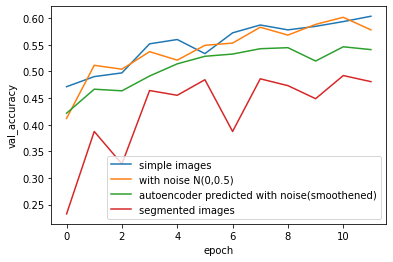

In [93]:
plt.plot(load_hist11.history['val_accuracy'])
plt.plot(load_hist12.history['val_accuracy'])
plt.plot(load_hist13.history['val_accuracy'])
plt.plot(load_hist14.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.legend(['simple images','with noise N(0,0.5)','autoencoder predicted with noise(smoothened)','segmented images'],loc='lower right')
plt.savefig('p1.png')

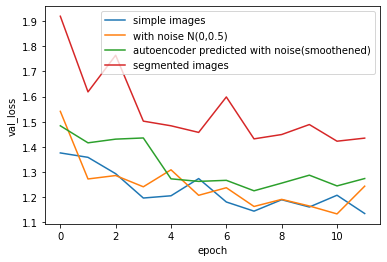

In [94]:
plt.plot(load_hist11.history['val_loss'])
plt.plot(load_hist12.history['val_loss'])
plt.plot(load_hist13.history['val_loss'])
plt.plot(load_hist14.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend(['simple images','with noise N(0,0.5)','autoencoder predicted with noise(smoothened)','segmented images'],loc='upper right')
plt.savefig('p2.png')

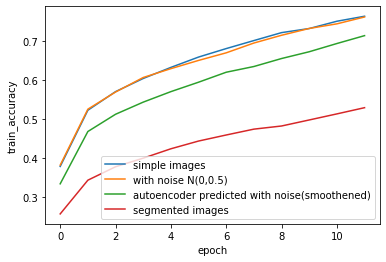

In [95]:
plt.plot(load_hist11.history['accuracy'])
plt.plot(load_hist12.history['accuracy'])
plt.plot(load_hist13.history['accuracy'])
plt.plot(load_hist14.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.legend(['simple images','with noise N(0,0.5)','autoencoder predicted with noise(smoothened)','segmented images'],loc='lower right')
plt.savefig('p3.png')

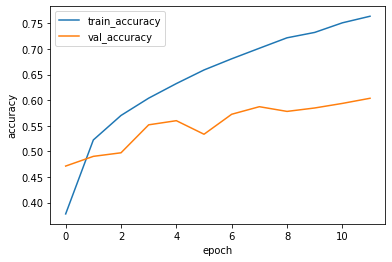

In [96]:
plt.plot(load_hist11.history['accuracy'])
plt.plot(load_hist11.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'],loc='upper left')
plt.savefig('p4.png')

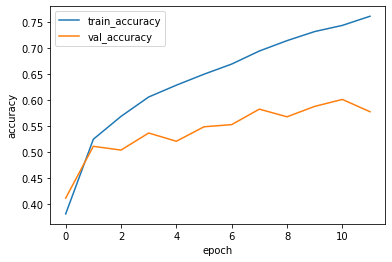

In [97]:
plt.plot(load_hist12.history['accuracy'])
plt.plot(load_hist12.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'],loc='upper left')
plt.savefig('p5.png')

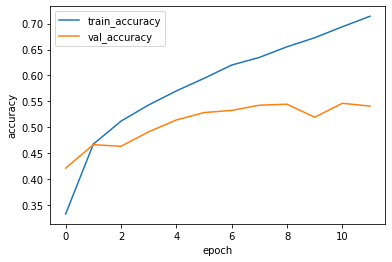

In [98]:
plt.plot(load_hist13.history['accuracy'])
plt.plot(load_hist13.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'],loc='upper left')
plt.savefig('p6.png')

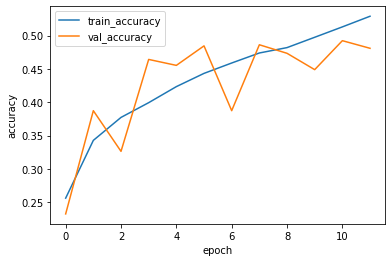

In [99]:
plt.plot(load_hist14.history['accuracy'])
plt.plot(load_hist14.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'],loc='upper left')
plt.savefig('p7.png')

# "Predicting on sample 640 * 480 pixel size images"

In [5]:
emotions={0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'suprise',6:'neutral'}

In [6]:
from PIL import Image

In [102]:
im11 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-00_img.tif')
im22 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-01_img.tif')
im33 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-02_img.tif')
im44 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-03_img.tif')
im55 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-04_img.tif')
im66 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-05_img.tif')
im77 = Image.open('C:\\Users\\Sohaib Fazal\\Desktop\\models\\s005-06_img.tif')

In [103]:
im11 = im11.resize((48,48))
im22 = im22.resize((48,48))
im33 = im33.resize((48,48))
im44 = im44.resize((48,48))
im55 = im55.resize((48,48))
im66 = im66.resize((48,48))
im77 = im77.resize((48,48))

In [104]:
image11 = np.array(im11)
image22 = np.array(im22)
image33 = np.array(im33)
image44 = np.array(im44)
image55 = np.array(im55)
image66 = np.array(im66)
image77 = np.array(im77)

In [105]:
image11 = cv2.cvtColor(image11,cv2.COLOR_BGR2GRAY)
image22 = cv2.cvtColor(image22,cv2.COLOR_BGR2GRAY)
image33 = cv2.cvtColor(image33,cv2.COLOR_BGR2GRAY)
image44 = cv2.cvtColor(image44,cv2.COLOR_BGR2GRAY)
image55 = cv2.cvtColor(image55,cv2.COLOR_BGR2GRAY)
image66 = cv2.cvtColor(image66,cv2.COLOR_BGR2GRAY)
image77 = cv2.cvtColor(image77,cv2.COLOR_BGR2GRAY)

In [106]:
image111 = image11.reshape(48,48,1)
image222 = image22.reshape(48,48,1)
image333 = image33.reshape(48,48,1)
image444 = image44.reshape(48,48,1)
image555 = image55.reshape(48,48,1)
image666 = image66.reshape(48,48,1)
image777 = image77.reshape(48,48,1)

In [107]:
real_images1=[]
real_images1.append(image111)
real_images1.append(image222)
real_images1.append(image333)
real_images1.append(image444)
real_images1.append(image555)
real_images1.append(image666)
real_images1.append(image777)

In [108]:
real_images1=np.array(real_images1)
real_images1.shape

(7, 48, 48, 1)

In [109]:
predictions_sample1 = load_mod11.predict_classes(real_images1)

In [110]:
predictions_sample1

array([3, 3, 3, 5, 3, 5, 5], dtype=int64)

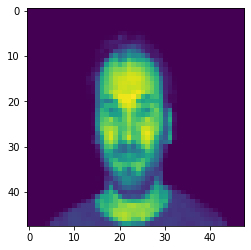

In [111]:
plt.imshow(image77)
plt.savefig('p8.png')

In [112]:
ans=predictions_sample1[6]
print(emotions[ans])

suprise


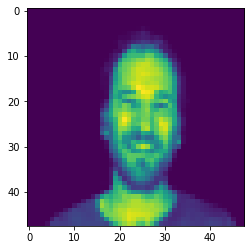

In [113]:
plt.imshow(image22)
plt.savefig('p9.png')

In [114]:
ans1=predictions_sample1[1]
print(emotions[ans1])

happy


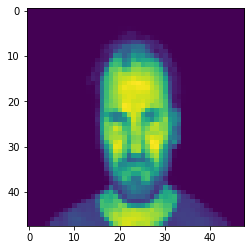

In [115]:
plt.imshow(image55)
plt.savefig('p10.png')

In [116]:
ans2=predictions_sample1[4]
print(emotions[ans2])

happy


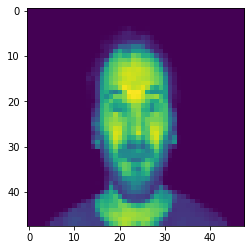

In [117]:
plt.imshow(image44)
plt.savefig('p11.png')

In [118]:
ans3=predictions_sample1[3]
print(emotions[ans3])

suprise


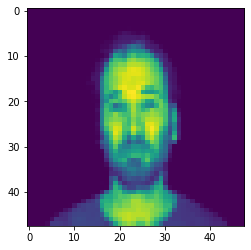

In [119]:
plt.imshow(image33)
plt.savefig('p12.png')

In [120]:
ans4=predictions_sample1[2]
print(emotions[ans4])

happy


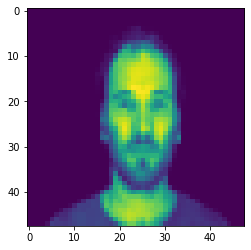

In [121]:
plt.imshow(image11)
plt.savefig('p13.png')

In [122]:
ans5=predictions_sample1[0]
print(emotions[ans5])

happy


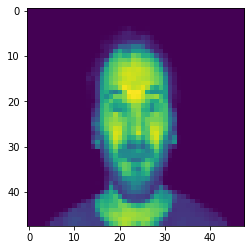

In [123]:
plt.imshow(image44)
plt.savefig('p14.png')

In [124]:
ans6=predictions_sample1[3]
print(emotions[ans6])

suprise


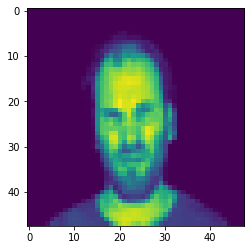

In [125]:
plt.imshow(image66)
plt.savefig('p15.png')

In [126]:
ans7=predictions_sample1[5]
print(emotions[ans7])

suprise
